# Getting Started with Pulsim

This notebook introduces the basics of circuit simulation with Pulsim.

## Contents
1. Creating a Simple RC Circuit
2. Running DC Analysis
3. Running a Transient Simulation
4. Analyzing and Plotting Results

## 1. Creating a Simple RC Circuit

Let's start by creating a simple RC low-pass filter circuit.

In [1]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidate_paths = []
for _ in range(6):
    for _rel in (('build-test', 'python'), ('build', 'python')):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidate_paths.append(candidate)
    _root = _root.parent

_unique_candidates = []
_seen = set()
for candidate in _candidate_paths:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    _unique_candidates.append(candidate)

_bootstrap_error = None
for candidate in _unique_candidates:
    cstr = str(candidate)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)
    try:
        import pulsim  # noqa: F401
        break
    except Exception as exc:
        _bootstrap_error = exc
        if cstr in sys.path:
            sys.path.remove(cstr)
else:
    if _bootstrap_error is not None:
        raise _bootstrap_error

import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

# Circuit parameters
V_SOURCE = 1.0   # 1V DC
R_VALUE = 1000   # 1kΩ
C_VALUE = 1e-6   # 1µF
TAU = R_VALUE * C_VALUE  # Time constant = 1ms

# Create a new circuit
ckt = ps.Circuit()
gnd = ckt.ground()  # Ground reference (node index -1)

# Add nodes
n_in = ckt.add_node("v_in")    # Input node
n_out = ckt.add_node("v_out")  # Output node

# Add components
ckt.add_voltage_source("Vin", n_in, gnd, V_SOURCE)  # 1V DC source
ckt.add_resistor("R1", n_in, n_out, R_VALUE)        # 1kΩ resistor
ckt.add_capacitor("C1", n_out, gnd, C_VALUE)        # 1µF capacitor

print(f"Circuit created!")
print(f"  Nodes: {ckt.num_nodes()}")
print(f"  System size: {ckt.system_size()}")
print(f"  Time constant τ = RC = {TAU*1000:.1f} ms")

Circuit created!
  Nodes: 2
  System size: 3
  Time constant τ = RC = 1.0 ms


In [ ]:
# Compat helper for Pulsim >=0.4 (Simulator API)
try:
    _PS = ps  # notebooks que usam alias 'ps'
except NameError:
    import pulsim as _PS

def run_transient_compat(circuit, t_start, t_stop, dt, x0=None, newton_options=None, linear_solver=None):
    """Bridge helper: mantem o retorno (times, states, success, msg) com a API atual."""

    def _legacy_call():
        args = []
        if x0 is not None:
            args.append(x0)
        if newton_options is not None:
            args.append(newton_options)
        if linear_solver is not None:
            args.append(linear_solver)
        return _PS.run_transient(circuit, t_start, t_stop, dt, *args)

    if hasattr(_PS, "SimulationOptions") and hasattr(_PS, "Simulator"):
        try:
            opts = _PS.SimulationOptions()
            opts.tstart = float(t_start)
            opts.tstop = float(t_stop)
            opts.dt = float(dt)

            if hasattr(opts, "dt_min"):
                opts.dt_min = min(float(opts.dt_min), float(dt))
            if hasattr(opts, "dt_max"):
                opts.dt_max = max(float(opts.dt_max), float(dt))

            if newton_options is not None:
                opts.newton_options = newton_options
            if linear_solver is not None and hasattr(opts, "linear_solver"):
                opts.linear_solver = linear_solver

            sim = _PS.Simulator(circuit, opts)
            if x0 is None:
                result = sim.run_transient()
            else:
                result = sim.run_transient(x0)
            if result.success or not hasattr(_PS, "run_transient"):
                return result.time, result.states, bool(result.success), str(result.message)

            # Fallback robusto para preservar notebooks mais antigos.
            return _legacy_call()
        except Exception:
            if hasattr(_PS, "run_transient"):
                return _legacy_call()
            raise

    return _legacy_call()


## 2. Running DC Analysis

First, let's find the DC operating point of the circuit.

In [2]:
# Run DC operating point analysis
dc_result = ps.dc_operating_point(ckt)

print(f"DC Analysis:")
print(f"  Success: {dc_result.success}")
print(f"  V_in = {dc_result.newton_result.solution[0]:.4f} V")
print(f"  V_out = {dc_result.newton_result.solution[1]:.4f} V")
print(f"")
print(f"In DC steady state, capacitor is open circuit:")
print(f"  → No current flows through R1")
print(f"  → V_out = V_in = {V_SOURCE} V")

DC Analysis:
  Success: True
  V_in = 1.0000 V
  V_out = 1.0000 V

In DC steady state, capacitor is open circuit:
  → No current flows through R1
  → V_out = V_in = 1.0 V


## 3. Running a Transient Simulation

Now let's simulate the circuit's step response - starting with capacitor discharged.

In [3]:
# Simulation parameters
t_stop = 5 * TAU  # Simulate for 5 time constants (5ms)
dt = TAU / 100    # 100 points per time constant

# Initial conditions: capacitor starts discharged (step response)
x0 = np.zeros(ckt.system_size())
x0[0] = V_SOURCE  # V_in = 1V (voltage source)
x0[1] = 0.0       # V_out = 0V (capacitor discharged)

# Run transient simulation
times, states, success, msg = run_transient_compat(ckt, 0.0, t_stop, dt, x0)

print(f"Transient Simulation:")
print(f"  Success: {success}")
print(f"  Time points: {len(times)}")
print(f"  Duration: {t_stop*1000:.1f} ms")

Transient Simulation:
  Success: True
  Time points: 501
  Duration: 5.0 ms


## 4. Analyzing and Plotting Results

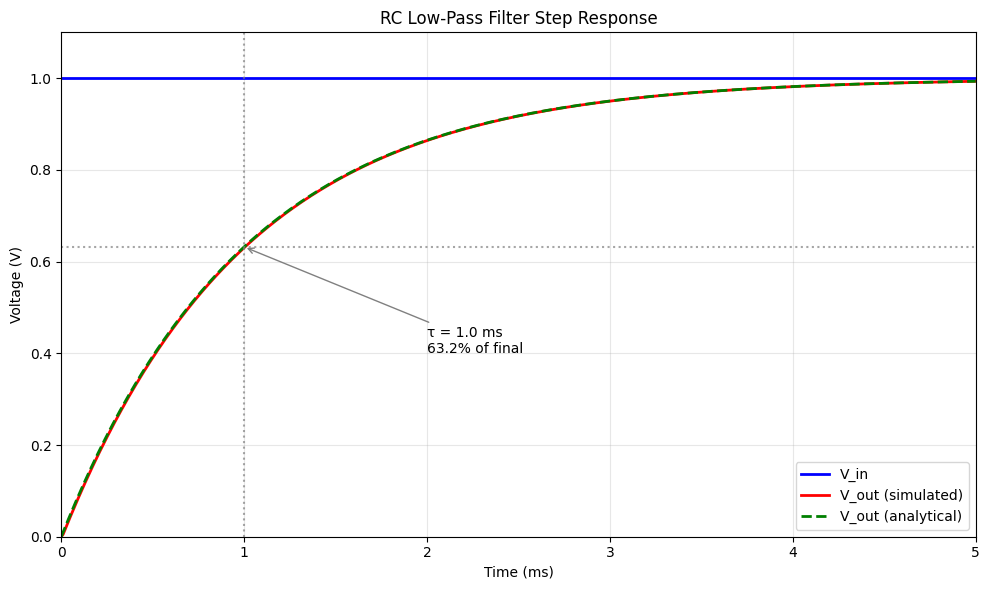

In [4]:
# Extract voltages
times = np.array(times)
v_in = np.array([s[0] for s in states])
v_out = np.array([s[1] for s in states])

# Analytical solution for RC step response
# V(t) = Vf * (1 - exp(-t/τ))
v_theory = V_SOURCE * (1 - np.exp(-times / TAU))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(times*1000, v_in, 'b-', label='V_in', linewidth=2)
plt.plot(times*1000, v_out, 'r-', label='V_out (simulated)', linewidth=2)
plt.plot(times*1000, v_theory, 'g--', label='V_out (analytical)', linewidth=2)

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.title('RC Low-Pass Filter Step Response')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, t_stop*1000])
plt.ylim([0, 1.1])

# Add time constant annotation
plt.axhline(y=0.632, color='gray', linestyle=':', alpha=0.7)
plt.axvline(x=TAU*1000, color='gray', linestyle=':', alpha=0.7)
plt.annotate(f'τ = {TAU*1000:.1f} ms\n63.2% of final', 
             xy=(TAU*1000, 0.632), 
             xytext=(TAU*1000 + 1, 0.4), fontsize=10,
             arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.show()

In [5]:
# Verify accuracy against analytical solution
error = np.abs(v_out - v_theory)
max_error = np.max(error)
rms_error = np.sqrt(np.mean(error**2))

print(f"Accuracy Analysis:")
print(f"  Maximum error: {max_error:.6f} V ({max_error/V_SOURCE*100:.4f}%)")
print(f"  RMS error: {rms_error:.6f} V ({rms_error/V_SOURCE*100:.4f}%)")
print(f"")
print(f"Simulation matches analytical solution within {max_error/V_SOURCE*100:.2f}%")

Accuracy Analysis:
  Maximum error: 0.004975 V (0.4975%)
  RMS error: 0.001578 V (0.1578%)

Simulation matches analytical solution within 0.50%


In [6]:
# Verify key points
print("Key Points Verification:")
print("="*50)

# At t = τ, voltage should be 63.2% of final
idx_tau = np.argmin(np.abs(times - TAU))
v_at_tau = v_out[idx_tau]
expected_at_tau = V_SOURCE * (1 - np.exp(-1))
print(f"At t = τ = {TAU*1000:.1f} ms:")
print(f"  Simulated: {v_at_tau:.4f} V")
print(f"  Expected:  {expected_at_tau:.4f} V (63.2%)")
print(f"  Error:     {abs(v_at_tau - expected_at_tau)*1000:.4f} mV")
print()

# At t = 5τ, voltage should be ~99.3% of final
v_final = v_out[-1]
expected_final = V_SOURCE * (1 - np.exp(-5))
print(f"At t = 5τ = {5*TAU*1000:.1f} ms:")
print(f"  Simulated: {v_final:.4f} V")
print(f"  Expected:  {expected_final:.4f} V (99.3%)")
print(f"  Error:     {abs(v_final - expected_final)*1000:.4f} mV")

Key Points Verification:
At t = τ = 1.0 ms:
  Simulated: 0.6303 V
  Expected:  0.6321 V (63.2%)
  Error:     1.8456 mV

At t = 5τ = 5.0 ms:
  Simulated: 0.9932 V
  Expected:  0.9933 V (99.3%)
  Error:     0.0336 mV


## Summary

In this notebook, you learned how to:
- Create circuits using `ps.Circuit()` and add nodes/components
- Run DC operating point analysis with `ps.dc_operating_point()`
- Run transient simulations with `ps.run_transient()`
- Extract and plot results
- Compare simulation results with analytical solutions

### Key API Functions

```python
# Create circuit
ckt = ps.Circuit()
gnd = ckt.ground()  # Returns -1 (ground node index)
node = ckt.add_node("name")

# Add components
ckt.add_resistor("R1", node1, node2, resistance)
ckt.add_capacitor("C1", node1, node2, capacitance)
ckt.add_inductor("L1", node1, node2, inductance)
ckt.add_voltage_source("V1", node_pos, node_neg, voltage)

# DC analysis
dc_result = ps.dc_operating_point(ckt)
solution = dc_result.newton_result.solution

# Transient simulation
times, states, success, msg = ps.run_transient(ckt, t_start, t_stop, dt, x0)
```

### Next Steps
- [Buck Converter Tutorial](02_buck_converter.ipynb)
- [Thermal Modeling](03_thermal_modeling.ipynb)
- [Parameter Sweeps](04_parameter_sweeps.ipynb)